# Importing libraries:

In [1]:
import cv2
import numpy as np
from PIL import Image
import h5py
import os
import random
import threading
import queue
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
root_path = "/content/gdrive/MyDrive/SegmentationDL/VOC/VOCdevkit/VOC2011"

In [4]:
def save_h5(file_path, data1, data2):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    with h5py.File(file_path, 'w') as hf:
        print("Saving data1...")
        hf.create_dataset('data1', data=data1)
        print("Saving data2...")
        hf.create_dataset('data2', data=data2)

In [5]:
class VOC2012:
    def __init__(self, root_path='/content/gdrive/MyDrive/SegmentationDL/VOC/VOCdevkit/VOC2011', image_size=(224, 224), resize_method='resize'):
        '''
        This function allows for the creation of a VOC2012 object containing the dataset with relevant functions
        Args:
            root_path: the Pascal VOC 2012 folder path
            image_size: resize all images and labels into this size
        '''
        self.root_path = root_path
        self.resize_method = resize_method

        if root_path[len(root_path) - 1] != '/' and root_path[len(root_path) - 1] != '\\':
            self.root_path += '/'
        self.train_names_path = self.root_path + 'ImageSets/Segmentation/train.txt'
        self.val_names_path = self.root_path + 'ImageSets/Segmentation/val.txt'
        self.image_path = self.root_path + 'JPEGImages/'
        self.label_path = self.root_path + 'SegmentationClass/'
        self.image_size = image_size
        if os.path.isfile(self.train_names_path):
            self.read_train_names()
        if os.path.isfile(self.val_names_path):
            self.read_val_names()

    def read_train_names(self):
        '''
        Read the filenames of training images and labels into self.train_list
        '''
        self.train_names = []
        f = open(self.train_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.train_names.append(line)
        f.close()

    def read_val_names(self):
        '''
        Read the filenames of validation images and labels into self.val_list
        '''
        self.val_names = []
        f = open(self.val_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.val_names.append(line)
        f.close()


    def get_train(self):
        '''
        Returns a "tuple" of lists containg all of the training images & labels respectively ... each element in each of the lists is a 224x224x3 numpy array representing an image.
        '''
        batch_images = []
        batch_labels = []

        for i in range(int(len(self.train_names))):
            image = cv2.imread(self.image_path + self.train_names[i] + '.jpg')
            if self.image_size:
                image = cv2.resize(image, self.image_size)
            label = np.array(Image.open(self.label_path + self.train_names[i] + '.png'))
            label[label > 20] = 0
            if self.image_size:
                label = cv2.resize(label, self.image_size, interpolation=cv2.INTER_NEAREST)
            batch_images.append(image)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)

    def get_val(self):
        '''
        Returns a "tuple" of lists containg all of the validation images & labels respectively ... each element in each of the lists is a 224x224x3 numpy array representing an image.
        '''
        batch_images = []
        batch_labels = []

        for i in range(int(len(self.val_names))):
            image = cv2.imread(self.image_path + self.val_names[i] + '.jpg')
            if self.image_size:
                image = cv2.resize(image, self.image_size)
            label = np.array(Image.open(self.label_path + self.val_names[i] + '.png'))
            label[label > 20] = 0
            if self.image_size:
                label = cv2.resize(label, self.image_size, interpolation=cv2.INTER_NEAREST)
            batch_images.append(image)
            batch_labels.append(label)
        return np.array(batch_images), np.array(batch_labels)


    def read_all_data_and_save(self, train_data_save_path='/content/gdrive/MyDrive/SegmentationDL/voc2011_train.h5', val_data_save_path='/content/gdrive/MyDrive/SegmentationDL/voc2011_val.h5'):
        '''
        Read training and validation data and save them into two .h5 files.
        Args:
            train_data_save_path:The path you want to save training data into.
            val_data_save_path:The path you want to save validation data into.
        '''
        self.read_train_images()
        self.read_train_labels()
        self.read_val_images()
        self.read_val_labels()
        self.save_train_data(train_data_save_path)
        self.save_val_data(val_data_save_path)

    def save_train_data(self, path='/content/gdrive/MyDrive/SegmentationDL/voc2011_train.h5'):
        '''
        save training images and labels into path in the form of .h5
        Args:
            path:The path you want to save train data into.It must be xxx.h5
        '''
        save_h5(path, self.train_images, self.train_labels)

    def save_val_data(self, path='/content/gdrive/MyDrive/SegmentationDL/voc2011_val.h5'):
        '''
        save validation images and labels into path in the form of .h5
        Args:
            path:The path you want to save train data into.It must be xxx.h5
        '''
        save_h5(path, self.val_images, self.val_labels)

    def load_all_data(self, train_data_load_path='/content/gdrive/MyDrive/SegmentationDL/voc2011_train.h5', val_data_load_path='/content/gdrive/MyDrive/SegmentationDL/voc2011_val.h5'):
        '''
        Load training and validation data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
            val_data_load_path:The validation data .h5 file path.
        '''
        self.load_train_data(train_data_load_path)
        self.load_val_data(val_data_load_path)

    def read_train_images(self):
        '''
        Read training images into self.train_images
        If you haven't called self.read_train_list(), it will call first
        After reading images, it will resize them
        '''
        self.train_images = []
        if hasattr(self, 'train_list') == False:
            self.read_train_list()
        for filename in self.train_list:
            image = cv2.imread(self.image_path + filename + '.jpg')
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            self.train_images.append(image)
            if len(self.train_images) % 100 == 0:
                print('Reading train images', len(self.train_images), '/', len(self.train_list))

    def read_train_labels(self):
        '''
        Read training labels into self.train_labels
        If you haven't called self.read_train_list(), it will call first
        After reading labels, it will resize them
        Note:image[image > 20] = 0 will remove all white borders in original labels
        '''
        self.train_labels = []
        if hasattr(self, 'train_list') == False:
            self.read_train_list()
        for filename in self.train_list:
            image = Image.open(self.label_path + filename + '.png')
            image = np.array(image)
            image[image > 20] = 0
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_NEAREST)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            image[image > 20] = 0
            self.train_labels.append(image)
            if len(self.train_labels) % 100 == 0:
                print('Reading train labels', len(self.train_labels), '/', len(self.train_list))

    def read_val_images(self):
        '''
           Read validation images into self.val_images
           If you haven't called self.read_val_list(), it will call first
           After reading images, it will resize them
        '''
        self.val_images = []
        if hasattr(self, 'val_list') == False:
            self.read_val_list()
        for filename in self.val_list:
            image = cv2.imread(self.image_path + filename + '.jpg')
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            self.val_images.append(image)
            if len(self.val_images) % 100 == 0:
                print('Reading val images', len(self.val_images), '/', len(self.val_list))

    def read_val_labels(self):
        '''
           Read validation labels into self.val_labels
           If you haven't called self.read_val_list(), it will call first
           After reading labels, it will resize them
           Note:image[image > 100] = 0 will remove all white borders in original labels
        '''
        self.val_labels = []
        if hasattr(self, 'val_list') == False:
            self.read_val_list()
        for filename in self.val_list:
            image = Image.open(self.label_path + filename + '.png')
            image = np.array(image)
            image[image > 20] = 0
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_NEAREST)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            image[image > 20] = 0
            self.val_labels.append(image)
            if len(self.val_labels) % 100 == 0:
                print('Reading val labels', len(self.val_labels), '/', len(self.val_list))

    def read_train_list(self):
        '''
        Read the filenames of training images and labels into self.train_list
        '''
        self.train_list = []
        f = open(self.train_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.train_list.append(line)
        f.close()

    def read_val_list(self):
        '''
        Read the filenames of validation images and labels into self.val_list
        '''
        self.val_list = []
        f = open(self.val_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.val_list.append(line)
        f.close()

    def load_all_data(self, train_data_load_path='/content/gdrive/MyDrive/SegmentationDL/voc2011_train.h5', val_data_load_path='/content/gdrive/MyDrive/SegmentationDL/voc2011_val.h5'):
        '''
        Load training and validation data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
            val_data_load_path:The validation data .h5 file path.
        '''
        self.load_train_data(train_data_load_path)
        self.load_val_data(val_data_load_path)

    def load_train_data(self, path='/content/gdrive/MyDrive/SegmentationDL/voc2011_train.h5'):
        '''
        Load training data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
        '''
        self.train_images, self.train_labels = load_h5(path)

    def load_val_data(self, path='/content/gdrive/MyDrive/SegmentationDL/voc2011_val.h5'):
        '''
        Load validation data from .h5 files
        Args:
            val_data_load_path:The validation data .h5 file path.
        '''
        self.val_images, self.val_labels = load_h5(path)

In [6]:
data = VOC2012()

In [7]:
train_images, train_labels = data.get_train()

In [8]:
print("The # of training samples is:", len(train_images))
print("The dimensions of each training image is:", train_images[0].shape)
print("The dimensions of each training label is:", train_labels[0].shape)

The # of training samples is: 1112
The dimensions of each training image is: (224, 224, 3)
The dimensions of each training label is: (224, 224)


In [9]:
val_images, val_labels = data.get_val()

In [ ]:
#data.read_all_data_and_save()

In [10]:
print("The # of validation samples is:", len(val_images))
print("The dimensions of each validation image is:", val_images[0].shape)
print("The dimensions of each validation label is:", val_labels[0].shape)

The # of validation samples is: 1111
The dimensions of each validation image is: (224, 224, 3)
The dimensions of each validation label is: (224, 224)


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
import h5py

In [12]:
from keras import models
from keras import layers

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Input, LSTM, Dense, Conv2D, MaxPooling2D, Reshape, BatchNormalization, Activation, Conv2DTranspose, Add, ZeroPadding2D, Cropping2D, UpSampling2D

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
from keras.backend import argmax
from keras.utils import to_categorical

# Importing data:

In [ ]:


#def load_h5(path):
#        print('loading',path)
#        file = h5py.File(name=path,mode='r')
#        return file['images'],file['labels']


#def load_train_data(path='/content/gdrive/MyDrive/SegmentationDL/voc2011_train.h5'):
        #'''
        #Load training data from .h5 files
        #Args:
        #    train_data_load_path:The training data .h5 file path.
        #'''
#       # return load_h5(path)

#def load_val_data(path='/content/gdrive/MyDrive/SegmentationDL/voc2011_val.h5'):
        #'''
        #Load validation data from .h5 files
        #Args:
        #    val_data_load_path:The validation data .h5 file path.
        #'''
#        return load_h5(path)




In [ ]:
#train_images, train_labels = load_train_data()
#val_images, val_labels = load_val_data()

#np.set_printoptions(threshold=np.inf)

# Pre-processing:

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


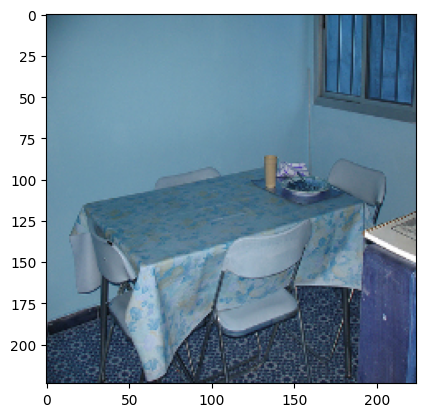

(1112, 224, 224)


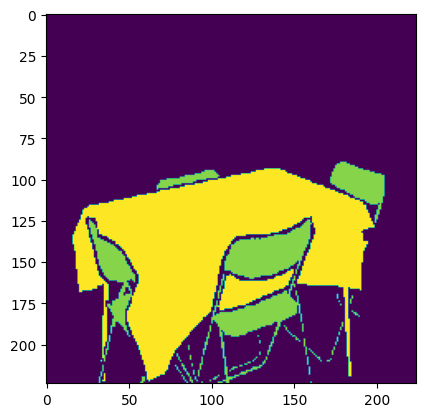

In [15]:
train_images=np.asarray(train_images)
train_labels=np.asarray(train_labels)
val_images=np.asarray(val_images)
val_labels=np.asarray(val_labels)

print(val_labels[100])

plt.figure()
plt.imshow(train_images[1000])
plt.show()
plt.imshow(train_labels[1000])
print(train_labels.shape)

Normalize the input pixels:

In [16]:
train_images = train_images/255
val_images = val_images/255

OneHot encoding:

In [17]:
#comment if ram crash

'''from keras.utils import to_categorical
y_trn= to_categorical(train_labels, num_classes=21)
y_val= to_categorical(val_labels, num_classes=21)'''

'from keras.utils import to_categorical\ny_trn= to_categorical(train_labels, num_classes=21)\ny_val= to_categorical(val_labels, num_classes=21)'

In [ ]:
#print(y_trn.shape)

The 4th axis of the labelled tensors refer to the 21 classes in our problem.

In [ ]:
# Check that the encoding is correct:
'''plt.figure()
plt.imshow(np.argmax(y_trn[1200], axis=2))
plt.show()'''

# Model:

In [18]:
num_classes=21

base_model = VGG16(include_top=False, weights='imagenet',input_shape=(224, 224, 3))
base_model.trainable=False

new_model = Sequential()

new_model.add(base_model)
new_model.add(Conv2D(4096, (7, 7), activation='tanh',
                padding='same'))
new_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
new_model.add(Dropout(0.5))
new_model.add((Conv2D(4096, (1, 1), activation='tanh',
                padding='same')))
new_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
new_model.add(Dropout(0.5))
new_model.add(Conv2D(num_classes,  (1, 1), kernel_initializer='he_normal'))
new_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
new_model.add(Conv2DTranspose(num_classes, kernel_size=(32, 32),  strides=(32, 32), use_bias=False))
new_model.add(Activation('softmax'))

new_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 4096)        102764544 
                                                                 
 batch_normalization (Batch  (None, 7, 7, 4096)        16384     
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 4096)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 4096)        16781312  
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 4096)        16

In [20]:
opt = Adam(learning_rate=0.001)
loss = 'sparse_categorical_crossentropy'
#'categorical_crossentropy -> sparse_categorical_crossentropy'
metrics = ['accuracy']
# 'categorical_accuracy' -> accuracy
epochs = 100
steps_per_epoch = 80
new_model.compile(optimizer=opt, loss=loss, metrics=metrics)
#train_labels -> y_trn
#val_labels -> y_val
history = new_model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=epochs, verbose=True, batch_size=20)

Epoch 1/100
56/56 [==============================] - 35s 583ms/step - loss: 1.6706 - accuracy: 0.7408 - val_loss: 1.2637 - val_accuracy: 0.7495
Epoch 2/100
56/56 [==============================] - 41s 745ms/step - loss: 1.3407 - accuracy: 0.7610 - val_loss: 1.3872 - val_accuracy: 0.7279
Epoch 3/100
56/56 [==============================] - 42s 758ms/step - loss: 1.1960 - accuracy: 0.7652 - val_loss: 2.1958 - val_accuracy: 0.6797
Epoch 4/100
56/56 [==============================] - 43s 768ms/step - loss: 1.1596 - accuracy: 0.7686 - val_loss: 3.4132 - val_accuracy: 0.5844
Epoch 5/100
56/56 [==============================] - 43s 776ms/step - loss: 1.0811 - accuracy: 0.7785 - val_loss: 2.8225 - val_accuracy: 0.5952
Epoch 6/100
56/56 [==============================] - 43s 773ms/step - loss: 1.0218 - accuracy: 0.7813 - val_loss: 1.9374 - val_accuracy: 0.6871
Epoch 7/100
56/56 [==============================] - 43s 775ms/step - loss: 0.9659 - accuracy: 0.7837 - val_loss: 1.7706 - val_accuracy:

The training accuracy is 93%.
The validation accuracy is 80%.

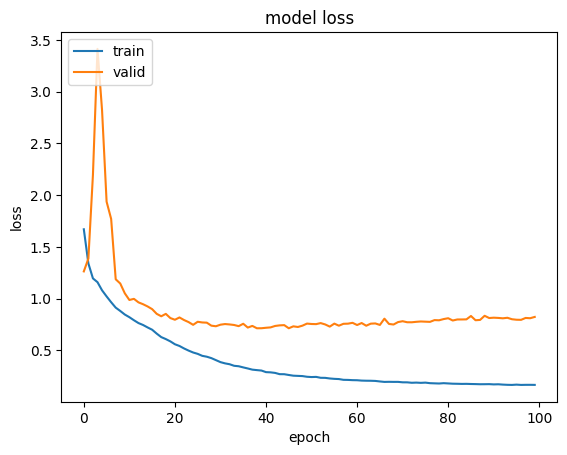

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

# Predict some samples after training is complete:

In [22]:
def show_result(img, index):

  x=img.reshape(1,224,224,3)

  d =new_model.predict(x)

  imclass = np.argmax(d, axis=3)[0,:,:]

  plt.figure(figsize = (15, 7))
  plt.subplot(1,3,1)
  plt.imshow( np.asarray(img) )
  plt.subplot(1,3,2)
  plt.imshow( np.asarray(img) )
  masked_imclass = np.ma.masked_where(imclass == 0, imclass)
  plt.imshow( masked_imclass, alpha=0.5 )

  plt.figure(figsize = (15, 7))
  plt.subplot(1,3,1, title='Our target')
  plt.imshow( val_labels[index] )
  plt.subplot(1,3,2, title='Our prediction')
  plt.imshow( imclass )

1/1 [==============================] - 2s 2s/step


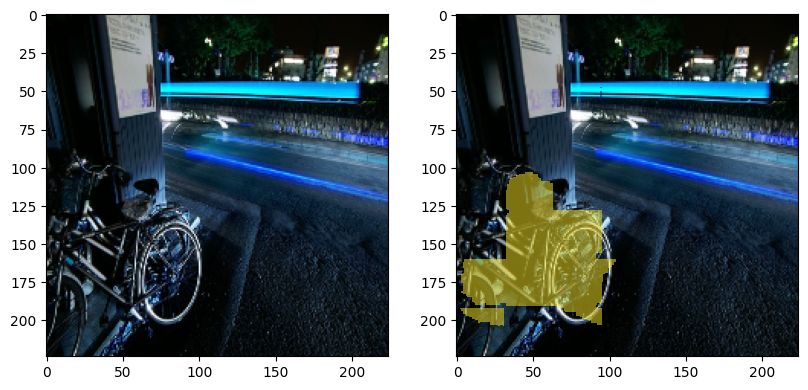

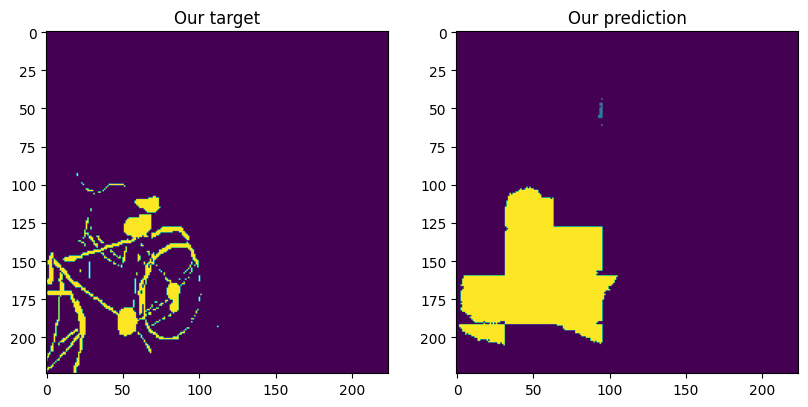

In [23]:
show_result(val_images[15], 15)

1/1 [==============================] - 0s 23ms/step


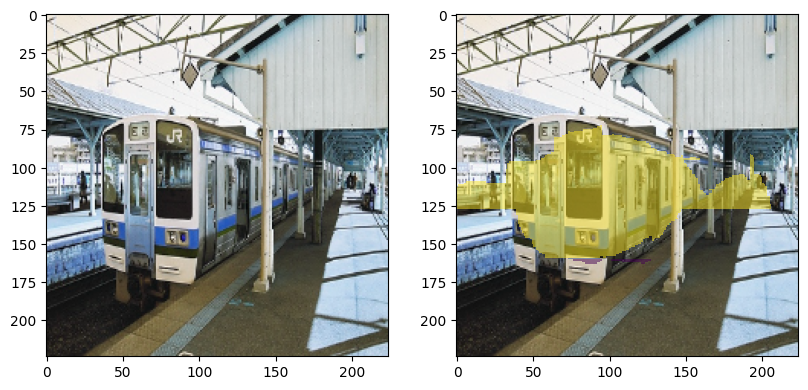

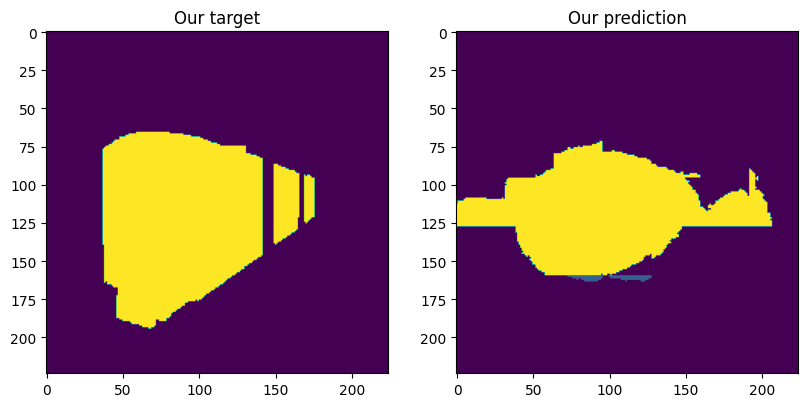

In [24]:
show_result(val_images[17], 17)

1/1 [==============================] - 0s 19ms/step


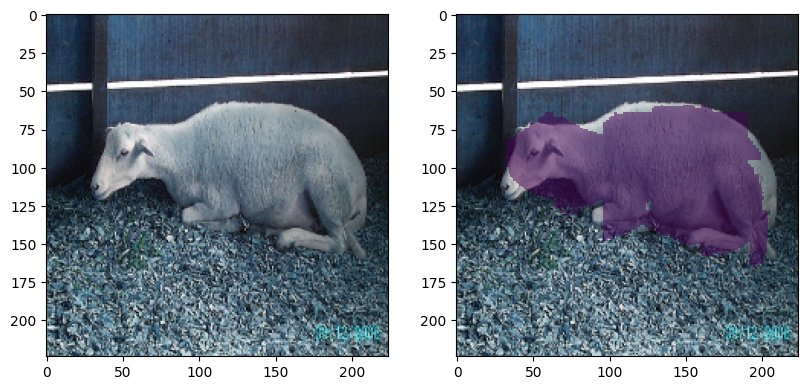

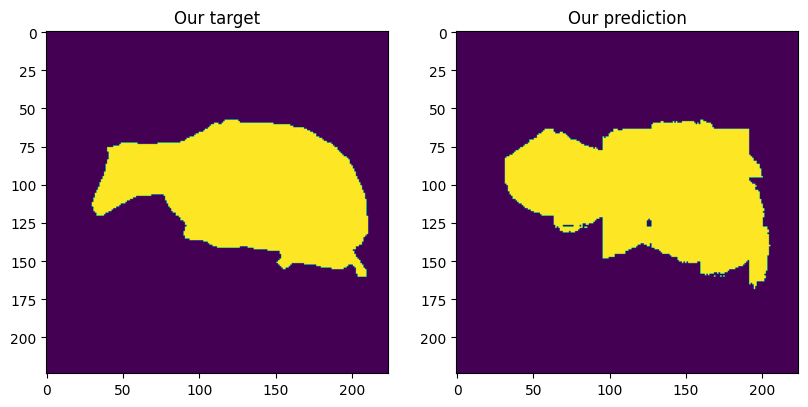

In [26]:
show_result(val_images[20], 20)

1/1 [==============================] - 0s 130ms/step


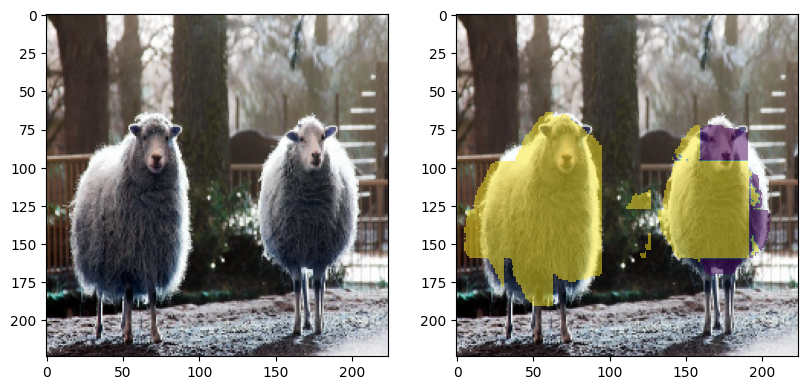

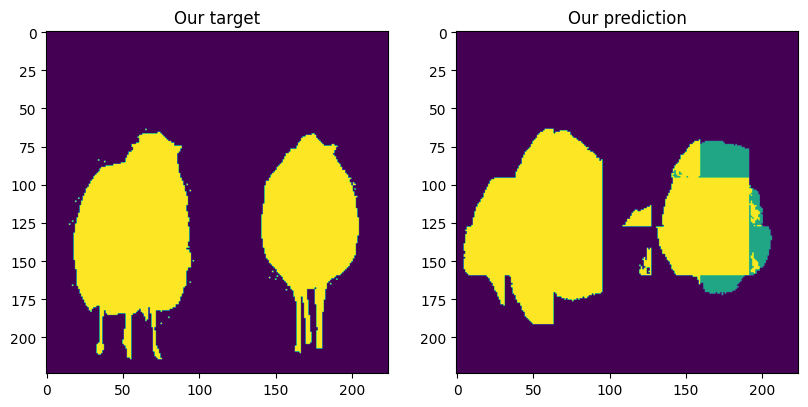

In [27]:
show_result(val_images[30], 30)

1/1 [==============================] - 0s 23ms/step


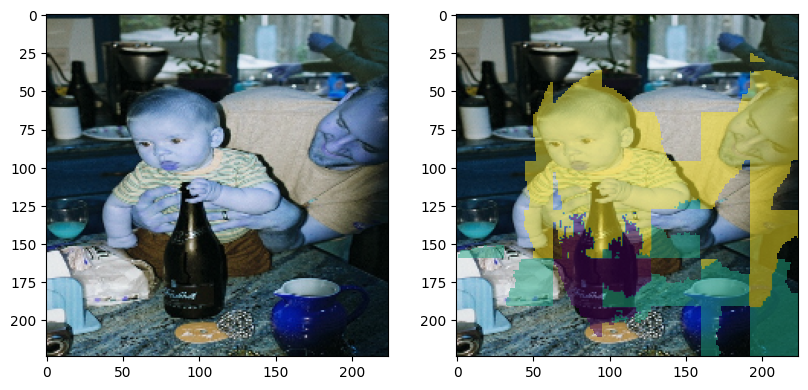

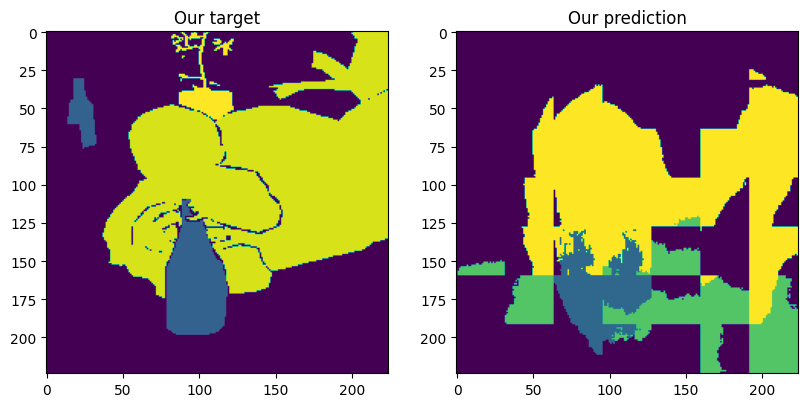

In [28]:
show_result(val_images[42], 42)

1/1 [==============================] - 0s 20ms/step


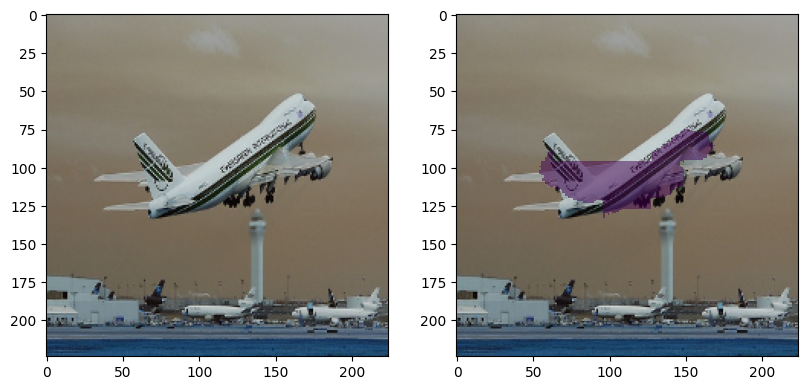

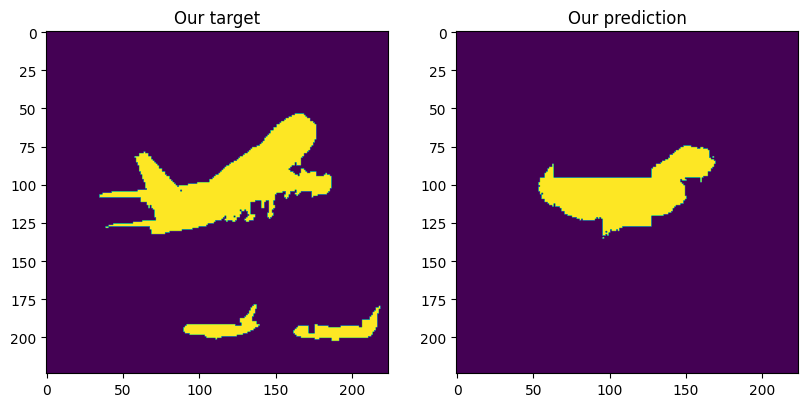

In [29]:
show_result(val_images[36], 36)